In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [3]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [68]:
numeric_features = [
    "pipe_dn","outside_diameter","wall_thickness","raised_face_depth","w_neck_c","flange_outer_radius",
    'length1', 'length2', 'lumped_mass',"flange_thickness_d","raised_face_radius"
    ]
categorical_features = ['support',"pipe_schedule","flange_class","support_right","support_left"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
        
    ],
    remainder='passthrough'
    )

In [69]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [70]:
normalised_data=pipeline.fit_transform(data)

In [71]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [73]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [74]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [100]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
"""hidden2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)"""
hidden3 = Dense(128, activation='relu')(dropout1)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'

In [101]:
model = Model(inputs=input_layer, outputs=output_layer)

In [102]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,641 (315.00 KB)

 Trainable params: 80,641 (315.00 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [104]:
logdir = "logs/Frequency/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [105]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - R2Score: 0.6254 - loss: 0.3637 - val_R2Score: 0.8967 - val_loss: 0.1092
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - R2Score: 0.8820 - loss: 0.1169 - val_R2Score: 0.9352 - val_loss: 0.0685
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - R2Score: 0.9192 - loss: 0.0808 - val_R2Score: 0.9438 - val_loss: 0.0594
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - R2Score: 0.9235 - loss: 0.0756 - val_R2Score: 0.9511 - val_loss: 0.0516
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9361 - loss: 0.0643 - val_R2Score: 0.9532 - val_loss: 0.0494
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - R2Score: 0.9452 - loss: 0.0502 - val_R2Score: 0.9594 - val_loss: 0.0429
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9500 - loss: 0.0490 - val_R2Score: 0.9591 - val_loss: 0.0433
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9506 - loss: 0.0511 - val_R2Score: 0.967

In [106]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - R2Score: 0.9908 - loss: 0.0083
Test accuracy: 0.9882423281669617


In [107]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,925 (945.02 KB)

 Trainable params: 80,641 (315.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,284 (630.02 KB)

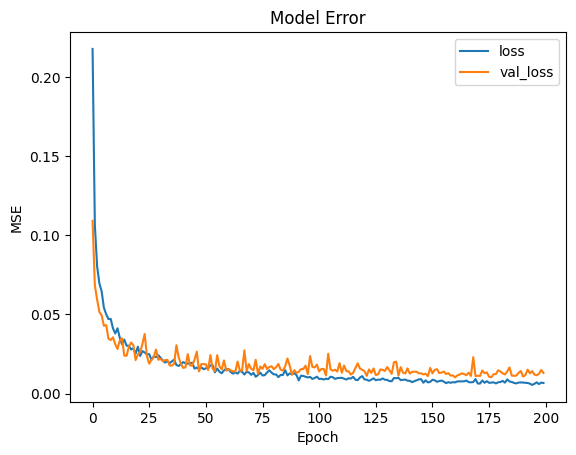

In [108]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()
plt.title("Model Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [109]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [110]:
predictions_df = pd.DataFrame(predictions)
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

5.8169748729031445

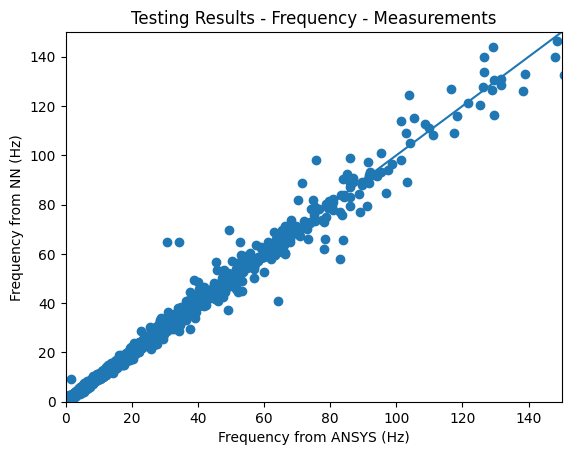

In [111]:
pred=predictions_df
ansys=y_test["frequency"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.xlim(0,150)
plt.ylim(0,150)
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Testing Results - Frequency - Measurements")
plt.show()

In [130]:
new_x_test_transformed = np.column_stack([x_test_transformed, y_test_transformed_frequency])

In [133]:
new_x_train_transformed = np.column_stack([x_train_transformed, y_train_transformed_frequency])

In [135]:
new_y_test_transformed = y_test_transformed_allowable_deformation
new_y_train_transformed = y_train_transformed_allowable_deformation

In [201]:
input_layer = Input(shape=(new_x_train_transformed.shape[1],))
hidden1 = Dense(256, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
"""hidden2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)"""
hidden3 = Dense(32, activation='relu')(dropout1)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'

In [184]:
allowable_deformation_model = Model(inputs=input_layer, outputs=output_layer)

In [185]:
allowable_deformation_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [186]:
allowable_deformation_history = allowable_deformation_model.fit(
    new_x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - R2Score: 0.5119 - loss: 0.4876 - val_R2Score: 0.9184 - val_loss: 0.0784
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.8933 - loss: 0.1126 - val_R2Score: 0.9387 - val_loss: 0.0589
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9148 - loss: 0.0719 - val_R2Score: 0.9302 - val_loss: 0.0671
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9265 - loss: 0.0719 - val_R2Score: 0.9478 - val_loss: 0.0502
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9403 - loss: 0.0630 - val_R2Score: 0.9561 - val_loss: 0.0421
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9451 - loss: 0.0579 - val_R2Score: 0.9541 - val_loss: 0.0441
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9545 - loss: 0.0465 - val_R2Score: 0.9041 - val_loss: 0.0921
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9277 - loss: 0.0660 - val_R2Score: 0.9275 - 

In [187]:
test_loss, test_mse = allowable_deformation_model.evaluate(new_x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9513 - loss: 0.0444
Test accuracy: 0.9601510763168335


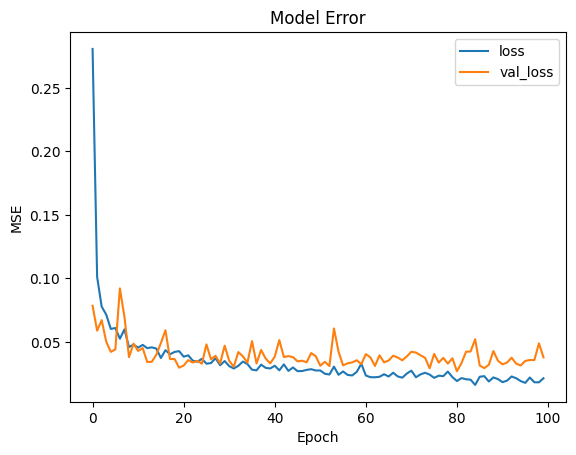

In [188]:
plt.plot(allowable_deformation_history.history["loss"],label="loss")
plt.plot(allowable_deformation_history.history["val_loss"],label="val_loss")
plt.legend()
plt.title("Model Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [189]:
predictions_scaled = allowable_deformation_model.predict(new_x_test_transformed)
predictions = scaler_y_allowable_deformation.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [190]:
predictions_df = pd.DataFrame(predictions)
true= y_test["allowable_deformation"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

251.82018333912518

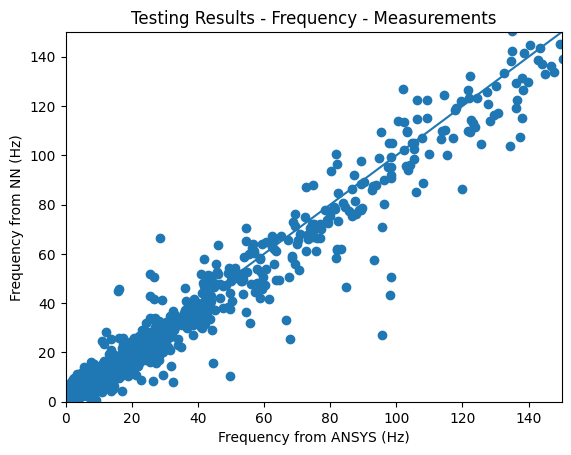

In [191]:
pred=predictions_df
ansys=y_test["allowable_deformation"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.xlim(0,150)
plt.ylim(0,150)
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Testing Results - Deformation - Contiuation from Frequency")
plt.show()

In [13]:
categorical_features = ['support',"pipe_schedule","flange_class","support_right","support_left"]

OHE_support = OneHotEncoder(drop=None)
OHE_pipe_schedule = OneHotEncoder(drop=None)
OHE_flange_class = OneHotEncoder(drop=None)
OHE_support_right = OneHotEncoder(drop=None)
OHE_support_left = OneHotEncoder(drop=None)


transformed_support = OHE_support.fit_transform(pd.DataFrame(data["support"]))
transformed_pipe_schedule = OHE_pipe_schedule.fit_transform(pd.DataFrame(data["pipe_schedule"]))
transformed_flange_class = OHE_flange_class.fit_transform(pd.DataFrame(data["flange_class"]))
transformed_support_right = OHE_support_right.fit_transform(pd.DataFrame(data["support_right"]))
transformed_support_left = OHE_support_left.fit_transform(pd.DataFrame(data["support_left"]))



In [4]:
corrolation2=data.corr("pearson",numeric_only=True)

In [5]:
corrolation2

,pipe_dn,flange_class,outside_diameter,length1,length2,wall_thickness,lumped_mass,raised_face_depth,w_neck_c,flange_outer_radius,flange_thickness_d,raised_face_radius,x_deformation_position,y_deformation_position,z_deformation_position,frequency,allowable_deformation
pipe_dn,1.000000,0.000580,0.998707,0.066911,0.018232,0.503897,0.663886,0.000670,0.871686,0.981354,0.700709,0.998060,-0.022298,0.271276,0.212378,0.345337,-0.135359
flange_class,0.000580,1.000000,0.000731,-0.025311,0.004119,0.000347,0.271242,0.945214,0.402040,0.152893,0.613499,0.000739,-0.012836,-0.043787,-0.246963,-0.087778,0.001876
outside_diameter,0.998707,0.000731,1.000000,0.067558,0.017848,0.513777,0.654964,0.000827,0.876773,0.982262,0.704643,0.999741,-0.022574,0.268870,0.209769,0.348695,-0.136763
length1,0.066911,-0.025311,0.067558,1.000000,-0.030501,0.054822,0.027024,-0.025391,0.045553,0.062892,0.025004,0.067932,0.355636,0.046948,0.129488,-0.362669,0.256400
length2,0.018232,0.004119,0.017848,-0.030501,1.000000,-0.005555,-0.000669,0.001173,0.017698,0.018589,0.016389,0.017631,-0.482654,0.091150,0.032450,-0.404695,-0.074845
wall_thickness,0.503897,0.000347,0.513777,0.054822,-0.005555,1.000000,0.296996,-0.001120,0.471776,0.504823,0.377594,0.515846,-0.001798,0.119023,0.141929,0.233459,-0.055525
lumped_mass,0.663886,0.271242,0.654964,0.027024,-0.000669,0.296996,1.000000,0.251367,0.723381,0.706689,0.702705,0.652773,-0.010475,0.170020,0.046060,0.113638,-0.080194
raised_face_depth,0.000670,0.945214,0.000827,-0.025391,0.001173,-0.001120,0.251367,1.000000,0.369683,0.133545,0.544609,0.000852,-0.011192,-0.050513,-0.253480,-0.076259,0.000373
w_neck_c,0.871686,0.402040,0.876773,0.045553,0.017698,0.471776,0.723381,0.369683,1.000000,0.945457,0.944172,0.878651,-0.029308,0.202791,0.018732,0.267487,-0.122203
flange_outer_radius,0.981354,0.152893,0.982262,0.062892,0.018589,0.504823,0.706689,0.133545,0.945457,1.000000,0.818345,0.982522,-0.025102,0.253526,0.143120,0.324218,-0.133133


<Axes: >

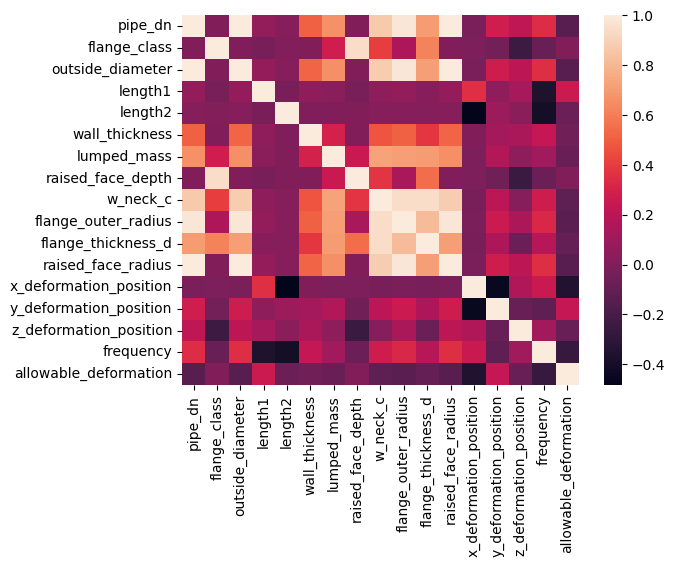

In [6]:
sns.heatmap(corrolation2)